In [2]:
import pandas as pd
import torch
import numpy as np

In [3]:
all_data = pd.read_csv('location_data.csv', index_col=0)

print(all_data)

                        id   latitude  longitude   price
0                     6499  38.697500  -9.197680    73.0
1                    25659  38.712410  -9.127060   106.0
2                    29396  38.711560  -9.129870    75.0
3                    29720  38.711080  -9.159790  1065.0
4                    29915  38.745710  -9.152640    95.0
...                    ...        ...        ...     ...
24259  1371008748532246224  38.721219  -9.167266  7411.0
24260  1371091268401865721  38.717077  -9.147289   200.0
24261  1371216308686882761  38.732713  -9.145716   110.0
24262  1371223704329486155  38.700770  -9.168950    59.0
24263  1371344702478038562  38.698704  -9.421072   200.0

[21079 rows x 4 columns]


In [4]:
all_data = all_data[['latitude', 'longitude', 'price']].to_numpy()

In [5]:
print(all_data)

[[ 38.6975     -9.19768    73.       ]
 [ 38.71241    -9.12706   106.       ]
 [ 38.71156    -9.12987    75.       ]
 ...
 [ 38.7327131  -9.1457157 110.       ]
 [ 38.70077    -9.16895    59.       ]
 [ 38.6987035  -9.4210724 200.       ]]


In [6]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


In [7]:
import torchvision.datasets as datasets

In [8]:
idx = np.arange(all_data.shape[0])
idx_shuffled = np.random.permutation(idx)

In [9]:
train_data_ratio = 0.8

train_idx = idx_shuffled[:int(0.8 * idx_shuffled.shape[0])]
test_idx = idx_shuffled[int(0.8 * idx_shuffled.shape[0]):]

train_data_raw = all_data[train_idx]
test_data_raw = all_data[test_idx]

print(train_data_raw)
print(test_data_raw)

[[ 38.71845     -9.14235    378.        ]
 [ 38.96828     -9.40644    140.        ]
 [ 38.74494917  -9.15095888 109.        ]
 ...
 [ 38.72058     -9.13107     88.        ]
 [ 38.71379664  -9.14734961 183.        ]
 [ 38.85017442  -9.44107896  61.        ]]
[[ 38.7197201   -9.1611328  200.        ]
 [ 38.71607     -9.13927     36.        ]
 [ 38.7252      -9.44184    100.        ]
 ...
 [ 38.72759     -9.1454      70.        ]
 [ 38.7178424   -9.1529954  173.        ]
 [ 38.71563685  -9.14525578 202.        ]]


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

n_estimators = 100
max_depth = 10

model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            
# normalization is not needed for random forests
X_train, y_train = train_data_raw[:, :2], train_data_raw[:, 2]
X_test, y_test = test_data_raw[:, :2], test_data_raw[:, 2]


def train_tree(model, X_train, y_train):
    # fit/train the model
    model.fit(X_train, y_train)
    return model

def eval_tree(model, X_test, y_test):
    # predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [34]:
estimator_sizes = [100, 200, 500, 1000, 1250, 1500, 1750, 2000]
max_depths = [5, 10, 15, 20, 25, 30]
mse_list = []

for n_estimators in estimator_sizes:
    mses = []
    for max_depth in max_depths:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

        train_tree(model, X_train, y_train)
        mse = eval_tree(model, X_test, y_test)

        mses.append(mse)

        print(f'Model with max_depth {max_depth} and number of estimators {n_estimators} has Mean Squared Error: {mse}')

    mse_list.append(mses)

print(mse_list)

Model with max_depth 5 and number of estimators 100 has Mean Squared Error: 244707.72443070216
Model with max_depth 10 and number of estimators 100 has Mean Squared Error: 217609.515544068
Model with max_depth 15 and number of estimators 100 has Mean Squared Error: 227532.20458661582
Model with max_depth 20 and number of estimators 100 has Mean Squared Error: 237270.46462388616
Model with max_depth 25 and number of estimators 100 has Mean Squared Error: 240514.60905122393
Model with max_depth 30 and number of estimators 100 has Mean Squared Error: 240490.7314061971
Model with max_depth 5 and number of estimators 200 has Mean Squared Error: 247065.1269568703
Model with max_depth 10 and number of estimators 200 has Mean Squared Error: 218294.594658328
Model with max_depth 15 and number of estimators 200 has Mean Squared Error: 226684.73994205156
Model with max_depth 20 and number of estimators 200 has Mean Squared Error: 238129.45758649905
Model with max_depth 25 and number of estimators

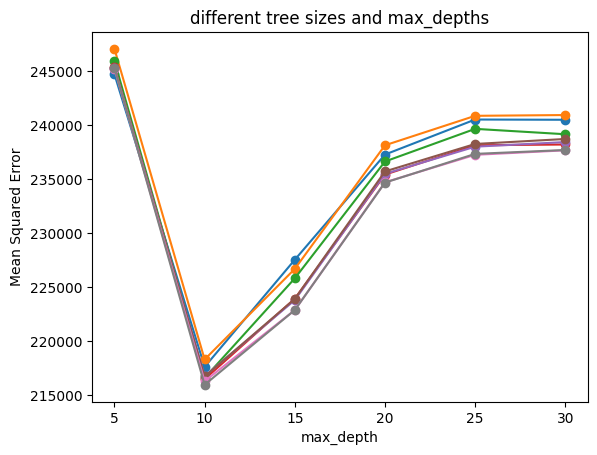

In [35]:
import matplotlib.pyplot as plt

for i in range(len(mse_list)):
        n_estimators = estimator_sizes[i]
        plt.plot(max_depths, mse_list[i], marker='o', label=f'{n_estimators} trees')

    
plt.title('different tree sizes and max_depths')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [37]:
#comparing to a dummy model
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print('Dummy MSE:', mean_squared_error(y_test, y_dummy))


Dummy MSE: 266363.37435548444


Maybe a transformation on logscale might help, like for plotting

In [39]:
y_train = np.log(y_train)
y_test = np.log(y_test)



n_estimators = 1000
max_depth = 10

model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

train_tree(model, X_train, y_train)
mse = eval_tree(model, X_test, y_test)

print(f'MSE: {mse}')

data_points = y_test

MSE: 0.01855753407303219


In [40]:
rmse = np.sqrt(mse)

erorr = np.exp(rmse)

In [42]:
print(erorr)

1.1459408932172663


In [11]:
all_data = pd.read_csv('location_data.csv', index_col=0)
all_data = all_data[['latitude', 'longitude', 'price']]
all_data = all_data[all_data['price'] < 1000]
print(all_data)

        latitude  longitude  price
0      38.697500  -9.197680   73.0
1      38.712410  -9.127060  106.0
2      38.711560  -9.129870   75.0
4      38.745710  -9.152640   95.0
5      38.764270  -9.153010   40.0
...          ...        ...    ...
24258  38.782674  -9.152600  136.0
24260  38.717077  -9.147289  200.0
24261  38.732713  -9.145716  110.0
24262  38.700770  -9.168950   59.0
24263  38.698704  -9.421072  200.0

[20880 rows x 3 columns]


In [12]:
all_data = all_data.to_numpy()

idx = np.arange(all_data.shape[0])
idx_shuffled = np.random.permutation(idx)

train_data_ratio = 0.8

train_idx = idx_shuffled[:int(0.8 * idx_shuffled.shape[0])]
test_idx = idx_shuffled[int(0.8 * idx_shuffled.shape[0]):]

train_data_raw = all_data[train_idx]
test_data_raw = all_data[test_idx]

print(train_data_raw)
print(test_data_raw)

[[ 38.71284     -9.15249     55.        ]
 [ 38.7302376   -9.1502026  374.        ]
 [ 38.71148     -9.14154    104.        ]
 ...
 [ 38.71178     -9.13825    147.        ]
 [ 38.7085146   -9.1539558   96.        ]
 [ 38.73096934  -9.13467373  19.        ]]
[[ 38.72318  -9.14493  42.     ]
 [ 38.71411  -9.15462  50.     ]
 [ 38.79265  -9.17533  66.     ]
 ...
 [ 38.78066  -9.09573 107.     ]
 [ 38.71717  -9.12713  40.     ]
 [ 39.00761  -9.41456  65.     ]]


In [13]:

X_train, y_train = train_data_raw[:, :2], train_data_raw[:, 2]
X_test, y_test = test_data_raw[:, :2], test_data_raw[:, 2]

n_estimators = 2000
max_depth = 10

model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

train_tree(model, X_train, y_train)
mse = eval_tree(model, X_test, y_test)

print(mse)


9261.189385287427


In [15]:
rmse = np.sqrt(mse)

print(f'RMSE is: {rmse}')

RMSE is: 96.23507357137224
